# **Sentiment Analysis On Tweets**

#Import libraries

In [ ]:
# utilities
import re
import numpy as np
import pandas as pd
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Read and Load Dataset

In [ ]:
def read_dataset(file):
  DATASET_COLUMNS=['target','ids','date','flag','user','text']
  DATASET_ENCODING = "ISO-8859-1"
  df = pd.read_csv(file, encoding=DATASET_ENCODING, names=DATASET_COLUMNS, engine='python')
  return df

In [ ]:
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2023-08-02 20:17:07--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  29.1MB/s    in 2.8s    

2023-08-02 20:17:10 (29.1 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


In [ ]:
file = 'data/training.1600000.processed.noemoticon.csv'
df = read_dataset(file)
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#Exploratory Data Analysis

In [ ]:
def explore(df):
  print('Columns: ',df.columns)
  print('Len: ', len(df))
  print('Shape: ', df.shape)
  print('Info: ', df.info())


In [ ]:
explore(df)

Columns:  Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')
Len:  1600000
Shape:  (1600000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
Info:  None


In [ ]:
#Checking for null values
np.sum(df.isnull().any(axis=1))

0

In [ ]:
#Checking unique target values
print('Unique target values: ', df['target'].unique())

#Check the number of target values
print('The number of target values: ', df['target'].nunique())

Unique target values:  [0 4]
The number of target values:  2


#Data Visualization Of Target Varialbles

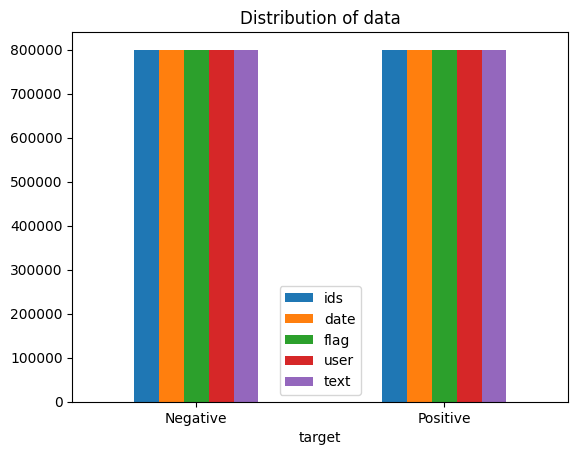

In [ ]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=True)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

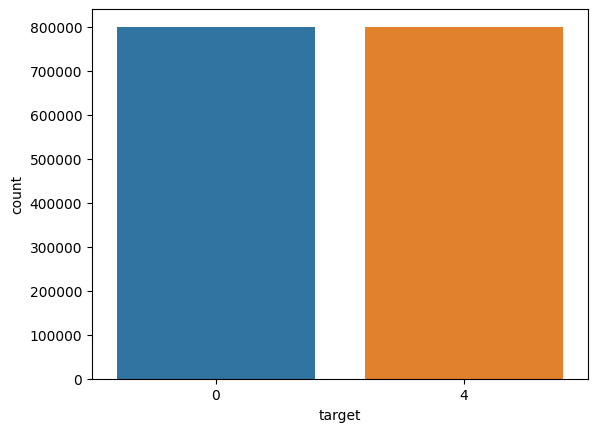

In [ ]:
sns.countplot(x='target', data = df)

In [ ]:
df.tail()

,target,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#Data Preprocessing

In [ ]:
def preprocess1(df):
  #Selecting the text and Target column for our further analysis
  dataset = df[['text', 'target']]

  #Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
  dataset['target'] = dataset['target'].replace(4,1)

  return dataset

In [ ]:
def preprocess_text(dataset):
  #Making statement text in lowercase
  dataset['text']=dataset['text'].str.lower()

  #Defining set containing all stopwords in English.
  stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'im', 'dont']

  #Cleaning and removing the stop words list from the tweet text
  STOPWORDS = set(stopwordlist)
  dataset['text'] = dataset['text'].apply(lambda text: " ".join([word for word in str(text).split() if word not in STOPWORDS]))

  #Cleaning and removing punctuations
  english_punctuations = string.punctuation
  punctuations_list = english_punctuations
  dataset['text']= dataset['text'].apply(lambda x: x.translate(str.maketrans('', '', punctuations_list)))

  #Cleaning and removing repeating characters
  dataset['text'] = dataset['text'].apply(lambda x: re.sub(r'(.)1+', r'1', x))

  #Cleaning and removing URLs
  dataset['text'] = dataset['text'].apply(lambda x: re.sub('((www.[^s]+)|(https?://[^s]+))',' ',x))

  #Cleaning and removing numeric numbers
  dataset['text'] = dataset['text'].apply(lambda x: re.sub('[0-9]+', '', x))

In [ ]:
dataset = preprocess1(df)
preprocess_text(dataset)

<ipython-input-36-4cde8303504e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['target'].replace(4,1)
<ipython-input-37-b9adb4529fa4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']=dataset['text'].str.lower()
<ipython-input-37-b9adb4529fa4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
dataset.tail()

,text,target
1599995,woke up no school best feeling ever,1
1599996,thewdbcom cool hear old walt interviews â« h...,1
1599997,ready mojo makeover ask details,1
1599998,happy th birthday boo alll time tupac amaru sh...,1
1599999,happy charitytuesday thenspcc sparkscharity sp...,1


In [ ]:
def tokenization(dataset):
  tokenizer = RegexpTokenizer(r'\w+')
  dataset['text'] = dataset['text'].apply(tokenizer.tokenize)

def stemming(dataset):
  st = nltk.PorterStemmer()
  def stemming_on_text(data):
      text = [st.stem(word) for word in data]
      return text
  dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))

def lemmatization(dataset):
  lm = nltk.WordNetLemmatizer()
  def lemmatizer_on_text(data):
      text = [lm.lemmatize(word) for word in data]
      return text
  dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))


In [ ]:
tokenization(dataset)
stemming(dataset)
lemmatization(dataset)
dataset['text'].tail()

<ipython-input-40-2e11e3c6ee2a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
<ipython-input-40-2e11e3c6ee2a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
<ipython-input-40-2e11e3c6ee2a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

1599995             [woke, up, no, school, best, feel, ever]
1599996    [thewdbcom, cool, hear, old, walt, interview, ...
1599997                   [readi, mojo, makeov, ask, detail]
1599998    [happi, th, birthday, boo, alll, time, tupac, ...
1599999    [happi, charitytuesday, thenspcc, sparkschar, ...
Name: text, dtype: object

In [ ]:
#Separating input feature and label
X=dataset.text
y=dataset.target

####Plot a cloud of words for negative tweets

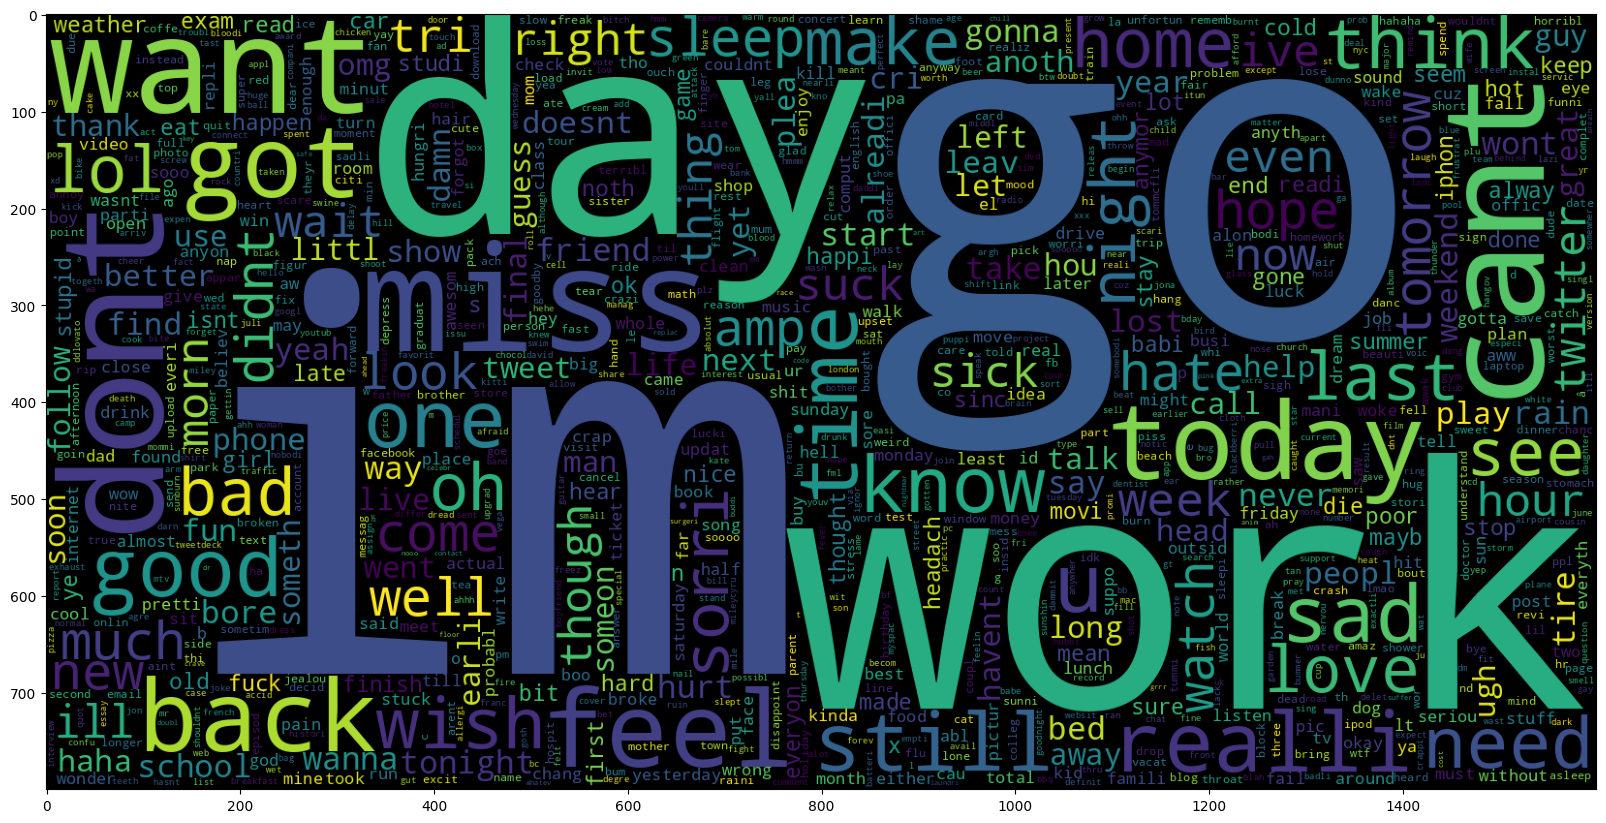

In [ ]:
from nltk.corpus import stopwords

data_neg = dataset['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join([' '.join(words) for words in data_neg]))
plt.imshow(wc)

####Plot a cloud of words for positive tweets

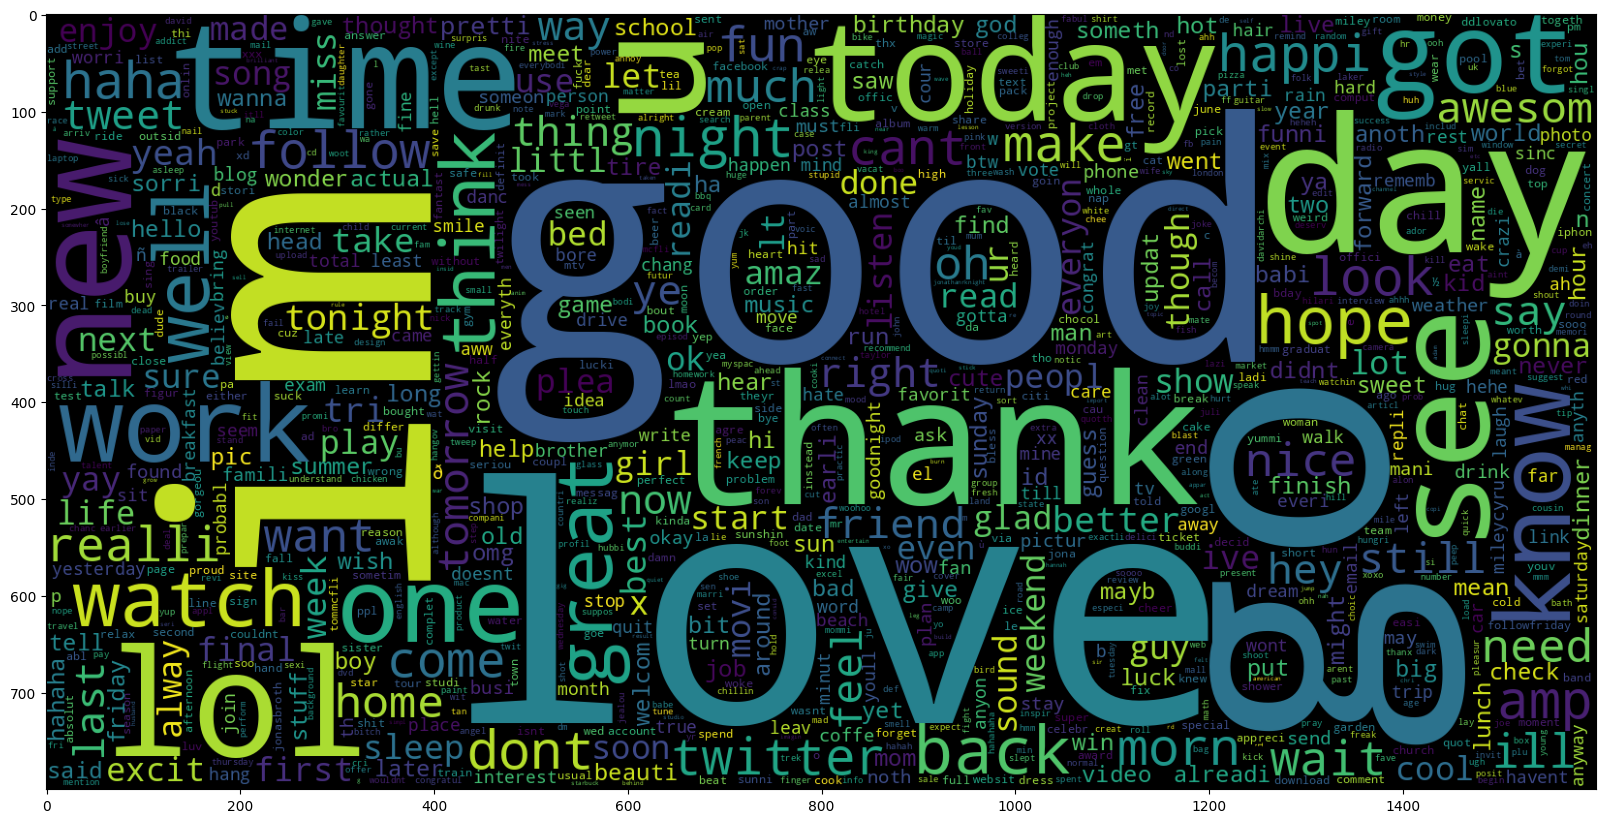

In [ ]:
data_pos = dataset['text'][800000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join([' '.join(words) for words in data_pos]))
plt.imshow(wc)

#Splitting Our Data Into Train and Test Subsets

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

#Transforming the Dataset Using TF-IDF Vectorizer

In [ ]:
#Fit the TF-IDF Vectorizer
X_train = [' '.join([ch.lower() for ch in x]) for x in X_train]
X_test = [' '.join([ch.lower() for ch in x]) for x in X_test]
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

#Transform the data using TF-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

#Function for Model Evaluation

In [ ]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#Model Building

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     40100
           1       0.79      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



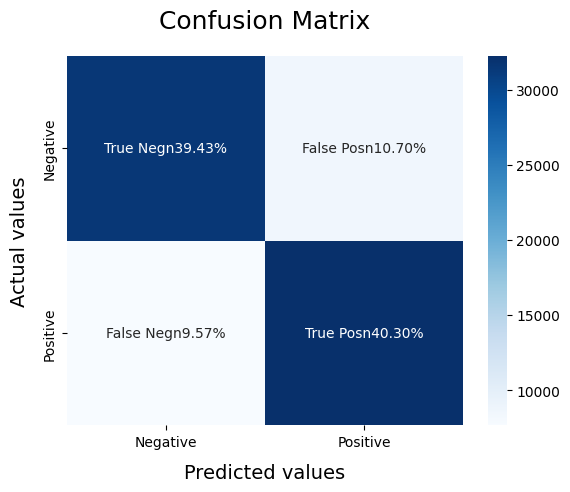

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

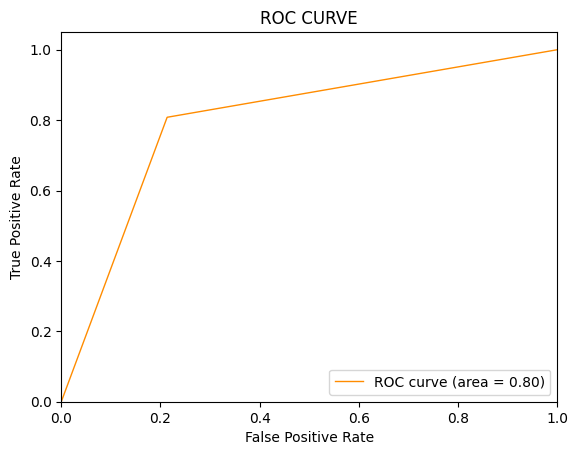

In [ ]:
#Plot the ROC-AUC Curve for model
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()